In [1]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.io as sio
import time
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from scipy.signal import butter, filtfilt
import time
from  utils import *

In [3]:
# Function to apply bandpass filter
def bandpass_filter(data, lowcut, highcut, sample_rate, order):
    '''
    Bandpass filters the input data.
    Args:
        data (numpy.ndarray): array of samples.
        lowcut (float): lower cutoff frequency (Hz).
        highcut (float): upper cutoff frequency (Hz).
        sample_rate (float): sampling rate (Hz).
        order (int): filter order.
    Returns:
        (numpy.ndarray): bandpass filtered data.
    '''
    b, a = butter(order, [lowcut, highcut], btype='band', fs=sample_rate)
    y = filtfilt(b, a, data)
    return y

# Function to compute FFT
def compute_fft(signal, sample_rate, start_freq, end_freq):
    '''
    Computes FFT of the input signal.
    Args:
        signal (numpy.ndarray): input signal (1D).
        sample_rate (float): sampling rate (Hz).
    Returns:
        freqs (numpy.ndarray): array of frequency bins.
        fft_vals (numpy.ndarray): FFT magnitude spectrum.
    '''
    N = len(signal)  # Length of the signal (1024 samples in this case)
    fft_vals = np.fft.fft(signal)
    fft_vals = 2 * np.abs(fft_vals) / N  # Normalized magnitude
    freqs = np.fft.fftfreq(N, 1/sample_rate)
    
    # Only take the positive frequencies (since FFT is symmetric)
    positive_freqs = freqs[:N//2]
    positive_fft_vals = fft_vals[:N//2]
    
    mask = (positive_freqs >= start_freq) & (positive_freqs <= end_freq)
    return positive_freqs[mask], positive_fft_vals[mask]

required_freqs = np.arange(9.25,15,0.25)
features = pd.DataFrame(index=[f'Target{i}' for i in range(1, 13)], columns=required_freqs)
base_path = r"E:\ain8sept\12JFPM_SSVEP\data"  # Base directory containing subject folders
subjects = [f's{i}' for i in range(1, 10)]  # Subject names s1 to s9
targets = [f'Target{i}' for i in range(1, 13)] 
target_folder = "Target1"  # Folder for the target files

# Example of using the functions for a single trial (1024 samples)
sample_rate = 256  # in Hz
lowcut = 6  # lower cutoff frequency in Hz
highcut = 80  # upper cutoff frequency in Hz
order = 4  # filter order
start_freq = 8  # start frequency in Hz
end_freq = 30  # end frequency in Hz
num_files = 15  # Number of files to process
num_trials_per_subject = 15

overall_fft_vals = None

# Loop through all targets
for target in targets:
    # Initialize variables for accumulating FFT values for the current target
    overall_fft_vals = None
    
    # Loop through all subjects
    for subject in subjects:
        subject_path = f"{base_path}/{subject}/{target}"
        
        # Loop through 15 files for each subject (15 trials per target)
        for trial_num in range(1, num_trials_per_subject + 1):
            # Load the file
            file_path = f"{subject_path}/{trial_num}.csv"
            data = pd.read_csv(file_path, header=None)
            
            # Example of using the functions for a single trial (1024 samples)
            single_trial = data.iloc[7, :]  # Replace with the appropriate row in your data
            
            # Apply bandpass filter
            filtered_signal = bandpass_filter(single_trial, lowcut, highcut, sample_rate, order)
            
            # Compute FFT
            freqs, fft_vals = compute_fft(filtered_signal, sample_rate, start_freq, end_freq)
            
            # Accumulate the FFT values for averaging across all subjects and trials
            if overall_fft_vals is None:
                overall_fft_vals = fft_vals
            else:
                overall_fft_vals += fft_vals

    # Average the FFT values across all subjects and trials (9 subjects * 15 trials = 135 trials)
    total_trials = len(subjects) * num_trials_per_subject
    average_fft_vals = overall_fft_vals / total_trials
    
    # Extract the FFT values corresponding to the required frequencies
    target_feature_vector = []
    for freq in required_freqs:
        # Find the index of the required frequency in the computed FFT results
        idx = np.argmin(np.abs(freqs - freq))
        target_feature_vector.append(average_fft_vals[idx])
    
    # Store the feature vector for this target in the DataFrame
    features.loc[target] = target_feature_vector

# Display the feature matrix
print(features)

# Optionally, save the feature matrix to a CSV file
features.to_csv(r"E:\ain8sept\12JFPM_SSVEP\data\o2_features.csv",index=True)


             9.25      9.50      9.75      10.00     10.25     10.50  \
Target1   2.437799  1.010725  1.087505  1.033566  0.977311  0.855008   
Target2   1.040644  0.893673  0.966141  0.908304  0.888287  0.835685   
Target3   1.014714  0.982815  0.945682  1.006372  0.889388  0.851506   
Target4   1.093797  1.215428  2.797481  0.985612  1.058787  0.790145   
Target5   1.041389  1.069509  0.999781  0.934408  0.827349  1.084298   
Target6   1.021965  0.967149  1.034886  1.097264  0.951681  0.830209   
Target7   1.217011  0.967973  1.172171  1.349087  3.135411  0.889186   
Target8   0.954248  1.021601   1.06095  0.922384  0.876607  0.908944   
Target9   1.038941  0.947626  1.090435   0.94089  0.991959  0.867167   
Target10  1.114534  1.007859  1.119302  1.244365  1.270888  1.307173   
Target11  1.045319  1.040643  1.177728  1.003236  0.932407  0.955703   
Target12  1.030884  0.977249  1.102348  0.984879  0.897452  0.858656   

             10.75     11.00     11.25     11.50  ...     12.50

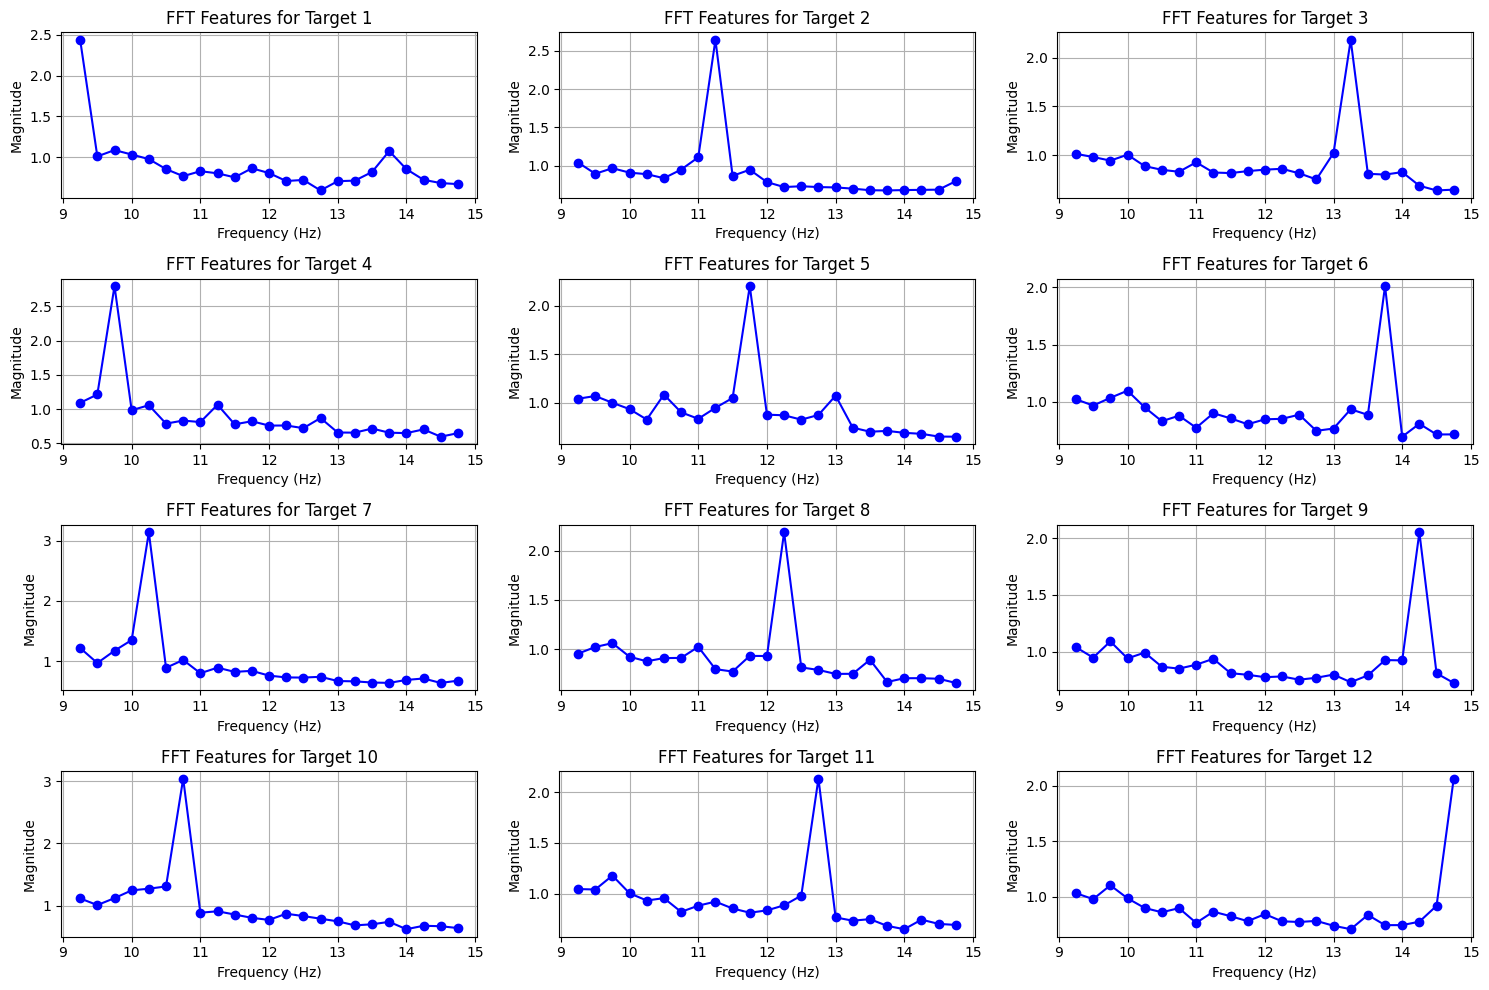

In [4]:
import matplotlib.pyplot as plt

# Assuming 'features' is your DataFrame with 12 rows (targets) and columns as 'required_freqs'
required_freqs = np.arange(9.25, 15, 0.25)  # Same as before
features = pd.read_csv(r"E:\ain8sept\12JFPM_SSVEP\data\o2_features.csv", header=None)

# Create a 4x3 grid of subplots
fig, axes = plt.subplots(4, 3, figsize=(15, 10))  # 4 rows, 3 columns, and size of the figure

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Iterate over each target and corresponding subplot
for i, target in enumerate(features.index):
    axes[i].plot(required_freqs, features.loc[target], marker='o', linestyle='-', color='b')  # Plot FFT values for this target
    axes[i].set_title(f'FFT Features for Target {target+1}')  # Set the title for each subplot
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Magnitude')
    axes[i].grid(True)

# Adjust layout for better display
plt.tight_layout()

# Show the plot
plt.show()